#   Instruções
  *-> Utilize uma conta com armazenamento disponível, pois serão baixados as imagens.*
  
  O sistema deve ser treinado para reconhecer pessoas autorizadas e não autorizadas a entrar em um recinto. Deve ser construída uma base de dados para treinamento do modelo contendo faces de pessoas autorizadas e não autorizadas. O sistema Home Security deverá possuir as seguintes funcionalidades:

    (a) Controlar o acesso de pessoas ao ambiente através do reconhecimento de face.
    (b) Capturar imagens a partir de uma câmera de qualquer tipo, que será utilizada para liberar ou negar o acesso a esta pessoa.
    (c) Utilizar algoritmos baseados em aprendizagem de máquina para autorização de acesso.
    (d) Consumir um web service na nuvem, cuja função será controlar as regras de acesso, conforme definido no algoritmo.

2. A API de detecção facial do Azure, disponível em https://azure.microsoft.com/pt-br/services/ cognitive-services/face/, deve ser usada para extrair atributos das faces.

3. Deve ser utilizado o processo completo de ciência de dados, que envolve a análise exploratória de dados,
para selecionar, limpar e transformar os atributos

4. Deve ser usada alguma técnica de aprendizado, supervisionado ou não supervisionado, com justicativa. ****O modelo gerado deve ser apresentado, bem como a validação do modelo.

5. O modelo deve ser disponibilizado no Azure (deploy).

6. Todo o processo, desde a coleta dos dados até a validação do modelo, deve ser documentado

# Modelagem

**Objetivo:** criar um sistema para acesso à casa branca, pessoas que possuem acesso autorizado são: Laura_Bush ou George_W_Bush


Steps: 

1. Criar uma base de dados que contenha 10 imagens de cada pessoa;
2. Definir os labels da base de dados. Os labels serão um atributo categórico nominal que representam nome das pessoas;
3. Realizar a chamada da API para obter as features das imagens;
4. A base de dados utilizada inclui o nome das pessoas (label) e as features que são extraídas na etapa 3;
5. Dividir a base em treino e teste, essa separação será realizada considerando os registros de cada pessoa. Exemplo, 20% teste e 80% treinamento. Para cada pessoa da base de dados, irá ter 8 imagens da pessoa na base de treino e 2 imagens dessa pessoa na base de teste. Sendo assim, se a base possui 100 pessoas, o tamanho total da base de dados é de 100x10 = 1000, a base de dados de treino possui tamanho igual a 800 e a base de teste tamanho igual a 200;
6. O Webservice terá o nome das pessoas autorizadas, nesse caso, Laura_Bush ou George_W_Bush. Essa informação poderá ser alterada a qualquer momento.
7. O sistema proposto deverá ser capaz de identificar cada uma das 10 pessoas. Então, a proposta é a criação de um sistema de classificação multiclasse.



Link Gallery Azure: https://gallery.cortanaintelligence.com/Experiment/Home-Security

In [0]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
import asyncio
import io
import glob
import os
import sys
import time
import uuid
import requests
import json
from urllib.parse import urlparse
from io import BytesIO
from PIL import Image, ImageDraw

!pip install --upgrade azure-cognitiveservices-vision-face
from azure.cognitiveservices.vision.face import FaceClient
from msrest.authentication import CognitiveServicesCredentials
from azure.cognitiveservices.vision.face.models import TrainingStatusType, Person, SnapshotObjectType, OperationStatusType

from time import sleep
import traceback
import seaborn as sns

Requirement already up-to-date: azure-cognitiveservices-vision-face in /usr/local/lib/python3.6/dist-packages (0.4.0)


# Concedendo acesso o Google Drive

Permita acesso ao Google Drive


In [0]:
%cd /content/sample_data
from google.colab import drive
drive.mount('/content/drive/')


/content/sample_data
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Import das imagens

In [0]:
#configuração das permissões para download keras
import os
os.environ['KAGGLE_USERNAME']="wendersonj"
os.environ['KAGGLE_KEY']="88c12c6b6922ec49faa2ca0d40427db3"
!pip install kaggle
import kaggle

Realiza a importação do conjunto de imagens da base no site da Kaggle e copia para o diretório temporário do Google Colab.

In [0]:

#dataset kaggle: https://www.kaggle.com/jessicali9530/lfw-dataset
!mkdir /content/sample_data/
!kaggle datasets download -d jessicali9530/lfw-dataset
!unzip -n lfw-dataset.zip #sempre pular, se ja existir

mkdir: cannot create directory ‘/content/sample_data/’: File exists
lfw-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  lfw-dataset.zip


Carrega a lista de dados contendo as imagens e caminho.

In [0]:
data = pd.read_csv('/content/sample_data/people.csv')
data=data[data['images'] >= 10]  #filtra os registros que possuem no minimo 10 imagens

Cria a lista de nomes e caminhos das imagens.

In [0]:
nomes=[]
for n in pd.unique(data['name']):
  nomes.append(str(n))
data['caminho'] = ''
nomesEspeciais=['George_HW_Bush', 'Laura_Bush']

caminhos=[]
for dirname, _, filenames in os.walk('/content/sample_data/lfw-deepfunneled/lfw-deepfunneled/'):
    for filename in filenames: 
        caminhos.append(dirname+'/'+filename)

print("Temos {0} imagens".format(len(caminhos)))
print(caminhos[:3])

Temos 13233 imagens
['/content/sample_data/lfw-deepfunneled/lfw-deepfunneled/Lenny_Wilkens/Lenny_Wilkens_0003.jpg', '/content/sample_data/lfw-deepfunneled/lfw-deepfunneled/Lenny_Wilkens/Lenny_Wilkens_0001.jpg', '/content/sample_data/lfw-deepfunneled/lfw-deepfunneled/Lenny_Wilkens/Lenny_Wilkens_0002.jpg']


Cria um pd.DataFrame contendo o caminho e o nome de cada uma das 10 imagens para 100 pessoas.

In [0]:
dataset=pd.DataFrame(columns=["id_nome", "nome", 'caminho'])

dataset
lim=10
i = 0

#procura por pessoas específicas
for n in nomesEspeciais:
    for c in caminhos:
        if i < lim:
            if n+'_0' in c: #'_0' pois há primeiros nomes iguais. isso garante que eu pego o nome completo
                dataset = dataset.append({'id_nome':nomes.index(n), 'nome':n, 'caminho':c}, ignore_index = True)
                i = i+1
        else:
            break
    i=0

#geração do arquivo contendo os registros com o caminho de cada imagem, limitadas a número (lim) de registro por nome
#max 100 pessoas -> [:100]
for n in nomes[:100-len(nomesEspeciais)]: #98, pois queremos laura e george bush (+2)
    if n in nomesEspeciais:
      print('.')
      break
    for c in caminhos:
        if i < lim:
            if n+'_0' in c: #'_0' pois há primeiros nomes iguais. isso garante que eu pego o nome completo
                dataset = dataset.append({'id_nome':nomes.index(n), 'nome':n, 'caminho':c}, ignore_index = True)
                i = i+1
        else:
            break
    i=0

.


# Chamada de API do Azure Facial Detection

In [0]:
#Chave e ponto de acesso (endpoint) da API do Azure Facial D.
KEY = '04a03b54d4e04f0eb7c300274ec12f9b'
ENDPOINT = 'https://face-student.cognitiveservices.azure.com/'

##Não alterar
face_client = FaceClient(ENDPOINT, CognitiveServicesCredentials(KEY))
face_api_url = ENDPOINT+'face/v1.0/detect'

In [0]:
train_face_ids = []
faces_detected = []
names = []
last_face=-1 #-1: nenhuma extração

Nesta seção é realizaedo a requisição à Azure para extrair as caracteríticas das imagens para criar a base de dados.

**Só executar para criar uma nova base ou testar poucas chamadas de requisições**

Para testes, alterar a variáável "qtd_faces" para o núúmero de requisiçõões testes.

Para gerar nova base, usar qtd_faces = 1000

In [0]:
params = {
    'returnFaceId': 'true',
    'returnFaceLandmarks': 'true',
    'returnFaceAttributes': 'age,gender,smile,headPose,facialHair,glasses,emotion,hair,makeup,occlusion,accessories,blur,exposure,noise',    
}

qtd_faces=2 #limite da api por minuto = 20
response = None
for i in range(last_face+1, qtd_faces):
    path = dataset['caminho'][i]
    data=open(path, 'r+b').read()
    headers = {'Ocp-Apim-Subscription-Key': KEY, 'Content-Type':'application/octet-stream', 'Content-Length':str(len(data))}

    while(response == None or not response.ok ):
      response = requests.post(face_api_url, params=params, data=data, headers=headers)
      if response.status_code == 429 :
        print("Erro por excesso de requisições. Aguardando ...")
        sleep(60) #caso dê falha de limite de requisiçãão, esperar 1 minuto
        response = None
        continue #reinicia o while
      if not response.json():
        print('fail')
      if response != None and response.ok and response.json(): #code 200 = requisicao ok ; response.json() será True se tiver itens.
        train_face_ids.append(response.json()[0]['faceId']) #adiciona o id unico que a azure deu para a deteccao da face em uma lista
        faces_detected.append(response.json()[0]) #adiciona todos os features de resposta da face em uma lista
        names.append(dataset['nome'][i]) #adiciona o nome em um novo vetor
        response = None
        print("request {0} realizado.".format(i))
        last_face += 1
        break
      else:
        print("Erro ", response.status_code, " - Falha na requisição.\n Resposta: ", response.json())
        response = None

# Transformação do JSON da API para DataFrame's Pandas

Esta etapa irá extrair das caracteríticas os seus recpetivos valores por atributo e inserir em um pd.DataFrame, com os atributos separados em suas colunas, ao invés do JSON que é retornado pela requisição anterior.

In [0]:
def generate_FL(df):
    
    """
    Tranforma o Dataframe FaceLandmarks.
    
    Padrão de entrada 
        
        atributo_1 atributo_2
    x   0.0        0.0
    y   1.0        1.0
    
    Padrão saída
    
    atributo_1_x atributo_1_y atributo_2_x atributo_2_y
     0.0           1.0          0.0         1.0

    Parameters
    ----------
    df : pd.Dataframe
        
    Returns
    -------
    result : pd.Dataframe
    
    """
    
    tuples = []
    for key, values in df.items():
        tuples.append((key + "_x", values[0]))
        tuples.append((key + "_y", values[1]))
    result = pd.DataFrame.from_dict(dict(tuples),orient='index').T
    
    return  result
  
def generate_FA(df, columns_accept):
    
    columns_except = ['smile','gender','age','glasses','accessories'] 
    tuples = []
    for column in df.columns: 
       if(column in columns_accept):
        if(column not in columns_except):
             for key, values in df[column].items():
                if(values != 'hair'):
                    for key_2, values_2 in values.items():
                        tuples.append((column + "_" + key_2, values_2))
        else:  
            if(column != 'accessories'):
                tuples.append((column, df[column]))
    return  pd.DataFrame.from_dict(dict(tuples),orient='index')

def generate_new_df(faces_detected):
    
    """
    Realiza o tratamento dos Dataframes e gera um Dataframe único para todas as imagens da base de dados.
    
    Parameters
    ----------
    faces_detected : pd.Dataframe
        
    Returns
    -------
    result : pd.Dataframe
    
    """

    lista_df =[]
    for i in range(len(faces_detected)):
        df_FL = pd.DataFrame.from_dict(faces_detected[i]['faceLandmarks'])
        df_FA = pd.DataFrame.from_dict(faces_detected[i]['faceAttributes'], orient='index').T

        df_FL = generate_FL(df_FL)
        df_FA = generate_FA(df_FA, ['gender','age'])

        df = pd.concat([df_FA.T, df_FL], axis=1)

        lista_df.append(df)
    
    result = pd.concat(lista_df)
    
    return result

In [0]:
features = generate_new_df(faces_detected)
features.insert(loc=len(features.columns), column='label', value=names)

Copia a base preparada para o diretório pessoal do Drive.

In [0]:
features.to_csv('features.csv', index=False) #Exporta a base da dos completa (atributos + labels)
!cp "/content/sample_data/features.csv" "/content/drive/My Drive/"

# Preparação dos bases, convertendo gênero e codificando os labels.


In [0]:
#Importando base.lfw : base completa
try:
  !cp "/content/drive/My Drive/base_lfw.csv" "/content/sample_data/"
except:
  print("Failed to import file")

#Para importar manualmente, descomente
'''
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
'''
base = pd.read_csv("base_lfw.csv")
base.describe()

,age,pupilLeft_x,pupilLeft_y,pupilRight_x,pupilRight_y,noseTip_x,noseTip_y,mouthLeft_x,mouthLeft_y,mouthRight_x,mouthRight_y,eyebrowLeftOuter_x,eyebrowLeftOuter_y,eyebrowLeftInner_x,eyebrowLeftInner_y,eyeLeftOuter_x,eyeLeftOuter_y,eyeLeftTop_x,eyeLeftTop_y,eyeLeftBottom_x,eyeLeftBottom_y,eyeLeftInner_x,eyeLeftInner_y,eyebrowRightInner_x,eyebrowRightInner_y,eyebrowRightOuter_x,eyebrowRightOuter_y,eyeRightInner_x,eyeRightInner_y,eyeRightTop_x,eyeRightTop_y,eyeRightBottom_x,eyeRightBottom_y,eyeRightOuter_x,eyeRightOuter_y,noseRootLeft_x,noseRootLeft_y,noseRootRight_x,noseRootRight_y,noseLeftAlarTop_x,noseLeftAlarTop_y,noseRightAlarTop_x,noseRightAlarTop_y,noseLeftAlarOutTip_x,noseLeftAlarOutTip_y,noseRightAlarOutTip_x,noseRightAlarOutTip_y,upperLipTop_x,upperLipTop_y,upperLipBottom_x,upperLipBottom_y,underLipTop_x,underLipTop_y,underLipBottom_x,underLipBottom_y
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,46.778000,103.46800,112.075000,145.342800,111.121400,125.074700,136.4267,106.634300,157.620700,144.764200,156.828600,86.541200,104.470300,114.715100,103.019500,96.660000,112.965500,103.44610,109.756500,103.468100,115.046400,110.371300,112.841600,133.749000,102.491600,162.118200,102.854800,138.722100,112.184700,145.46000,108.780400,145.725200,114.047700,152.376900,111.729100,118.354100,113.577600,130.839900,113.307500,115.687900,128.939100,134.2526,128.584700,111.265900,137.389400,139.188100,136.845300,125.438800,152.170200,125.532500,156.048000,125.686300,161.424600,125.873500,167.214000
std,12.894999,6.28897,3.050039,6.391599,3.296384,6.748269,4.1985,6.158901,4.567019,6.344438,4.907291,7.125447,3.944295,6.224912,3.263326,6.370416,3.138807,6.10912,3.102942,6.061764,3.046209,5.907772,2.989034,6.317055,3.404115,7.331955,4.271431,5.952856,3.151706,6.18579,3.381179,6.140217,3.288204,6.482811,3.483984,5.804934,2.858785,5.777109,2.923262,5.915858,3.257028,5.9693,3.367253,5.951501,3.404723,6.003775,3.592328,5.878586,4.353765,5.880319,4.421403,5.887416,5.140188,5.965032,5.610333
min,20.000000,23.80000,67.000000,67.700000,53.600000,46.200000,84.0000,11.100000,110.000000,57.500000,101.200000,8.100000,54.000000,36.800000,55.100000,17.100000,65.600000,25.50000,63.900000,24.400000,68.800000,31.800000,66.000000,52.700000,50.300000,79.700000,36.100000,59.700000,56.200000,66.70000,49.200000,67.600000,56.300000,73.400000,50.000000,40.600000,64.400000,53.600000,60.900000,34.200000,79.800000,54.8000,75.500000,27.300000,91.800000,59.200000,82.800000,39.300000,102.900000,37.700000,107.000000,35.900000,109.000000,34.400000,114.700000
25%,33.000000,101.50000,111.000000,143.600000,110.100000,122.600000,134.5000,104.575000,155.800000,142.600000,154.700000,83.775000,102.600000,113.000000,102.100000,94.500000,111.700000,101.70000,108.700000,101.800000,113.900000,108.900000,111.800000,132.300000,101.600000,159.500000,101.300000,137.700000,111.100000,144.10000,107.700000,144.400000,112.900000,150.575000,110.700000,117.400000,112.600000,130.000000,112.300000,114.375000,127.600000,132.9000,127.200000,109.800000,136.100000,137.600000,135.500000,124.100000,150.800000,124.200000,154.775000,124.200000,158.700000,124.300000,164.100000
50%,50.000000,103.60000,112.100000,145.500000,111.200000,125.100000,136.3000,106.850000,157.400000,144.800000,156.700000,86.700000,104.600000,114.750000,103.300000,96.800000,113.100000,103.50000,109.800000,103.600000,115.00000

In [0]:
base.replace('female', 0, inplace=True)
base.replace('male', 1, inplace=True)

nomes = pd.unique(base['label'])
print(nomes)
for i in range(len(nomes)):
    base.replace(nomes[i], i, inplace=True)

['Hillary_Clinton' 'Jiang_Zemin' 'Ann_Veneman' 'Edmund_Stoiber'
 'Gordon_Brown' 'Gray_Davis' 'Hugo_Chavez' 'Jacques_Rogge'
 'Jennifer_Garner' 'Jeremy_Greenstock' 'John_Snow' 'Kim_Clijsters'
 'Lance_Armstrong' 'Lleyton_Hewitt' 'Nestor_Kirchner' 'Paul_Bremer'
 'Pervez_Musharraf' 'Ricardo_Lagos' 'Tom_Ridge' 'Tommy_Thompson'
 'Trent_Lott' 'Abdullah_Gul' 'Adrien_Brody' 'Andre_Agassi'
 'Anna_Kournikova' 'Bill_Gates' 'Catherine_Zeta-Jones' 'David_Beckham'
 'Howard_Dean' 'Hu_Jintao' 'Jacques_Chirac' 'Jason_Kidd'
 'Lindsay_Davenport' 'Mohammad_Khatami' 'Saddam_Hussein' 'Salma_Hayek'
 'Silvio_Berlusconi' 'Spencer_Abraham' 'Tony_Blair' 'Vicente_Fox'
 'Walter_Mondale' 'Dick_Cheney' 'Eduardo_Duhalde' 'Jiri_Novak'
 'Keanu_Reeves' 'Megawati_Sukarnoputri' 'Mohammed_Al-Douri' 'Norah_Jones'
 'Renee_Zellweger' 'Rubens_Barrichello' 'Taha_Yassin_Ramadan' 'Wen_Jiabao'
 'Andy_Roddick' 'Colin_Powell' 'Fidel_Castro' 'Jennifer_Capriati'
 'John_Paul_II' 'Joschka_Fischer' 'Julie_Gerberding' 'Muhammad_Ali'
 'Paul_

In [0]:
base.to_csv('base_preprocess.csv', index=False) #Exporta a base da dos completa (atributos + labels)
!cp "/content/sample_data/base_preprocess.csv" "/content/drive/My Drive/"

# Análise Estatíticas - BoxPlots

In [0]:

# groups boxplots : left eye and eyebrow x, left eye and eyebrow y, 
#          right eye and eyebrow x, right eye and eyebrow y,
#          mouth and lip x, mouth and lip y
#          nose x, nose y
landmarks_names = ['pupilLeft_x','eyebrowLeftOuter_x','eyebrowLeftInner_x','eyeLeftOuter_x','eyeLeftTop_x','eyeLeftBottom_x','eyeLeftInner_x',
                'pupilLeft_y','eyebrowLeftOuter_y','eyebrowLeftInner_y','eyeLeftOuter_y','eyeLeftTop_y','eyeLeftBottom_y', 'eyeLeftInner_y',
                'pupilRight_x','eyebrowRightInner_x','eyebrowRightOuter_x','eyeRightInner_x','eyeRightTop_x','eyeRightBottom_x','eyeRightOuter_x',
                'pupilRight_y','eyebrowRightInner_y','eyebrowRightOuter_y','eyeRightInner_y','eyeRightTop_y','eyeRightBottom_y','eyeRightOuter_y',
                'noseTip_x','noseRootLeft_x','noseRootRight_x','noseLeftAlarTop_x','noseRightAlarTop_x','noseLeftAlarOutTip_x','noseRightAlarOutTip_x',
                'noseTip_y','noseRootLeft_y','noseRootRight_y','noseLeftAlarTop_y','noseRightAlarTop_y','noseLeftAlarOutTip_y','noseRightAlarOutTip_y',
                'mouthLeft_x','mouthRight_x','upperLipTop_x','upperLipBottom_x','underLipTop_x','underLipBottom_x',
                'mouthLeft_y','mouthRight_y','upperLipTop_y','upperLipBottom_y','underLipTop_y','underLipBottom_y']
                      
landmarks_boxplot_names = [['pupilL_x','eyebLO_x','eyebLI_x','eyeLO_x','eyeLTop_x','eyeLB_x','eyeLI_x'],
               ['pupilL_y','eyebLO_y','eyebLI_y','eyeLO_y','eyeLTop_y','eyeLB_y','eyeLI_y'],
               ['pupilR_x','eyebRI_x','eyebRO_x','eyeRI_x','eyeRTop_x','eyeRB_x','eyeRO_x'],
               ['pupilR_y','eyebRI_y','eyebRO_y','eyeRI_y','eyeRTop_y','eyeRB_y','eyeRO_y'],
               ['noseT_x','noseRL_x','noseRR_x','noseLAT_x','noseRAT_x','noseLAOT_x','noseRAOT_x'],
               ['noseT_y','noseRL_y','noseRR_y','noseLAT_y','noseRAT_y','noseLAOT_y','noseRAOT_y'],
               ['mouthL_x','mouthR_x','upLipT_x','upLipB_x','unLipT_x','unLipB_x'],
               ['mouthL_y','mouthR_y','upLipT_y','upLipB_y','unLipT_y','unLipB_y']]

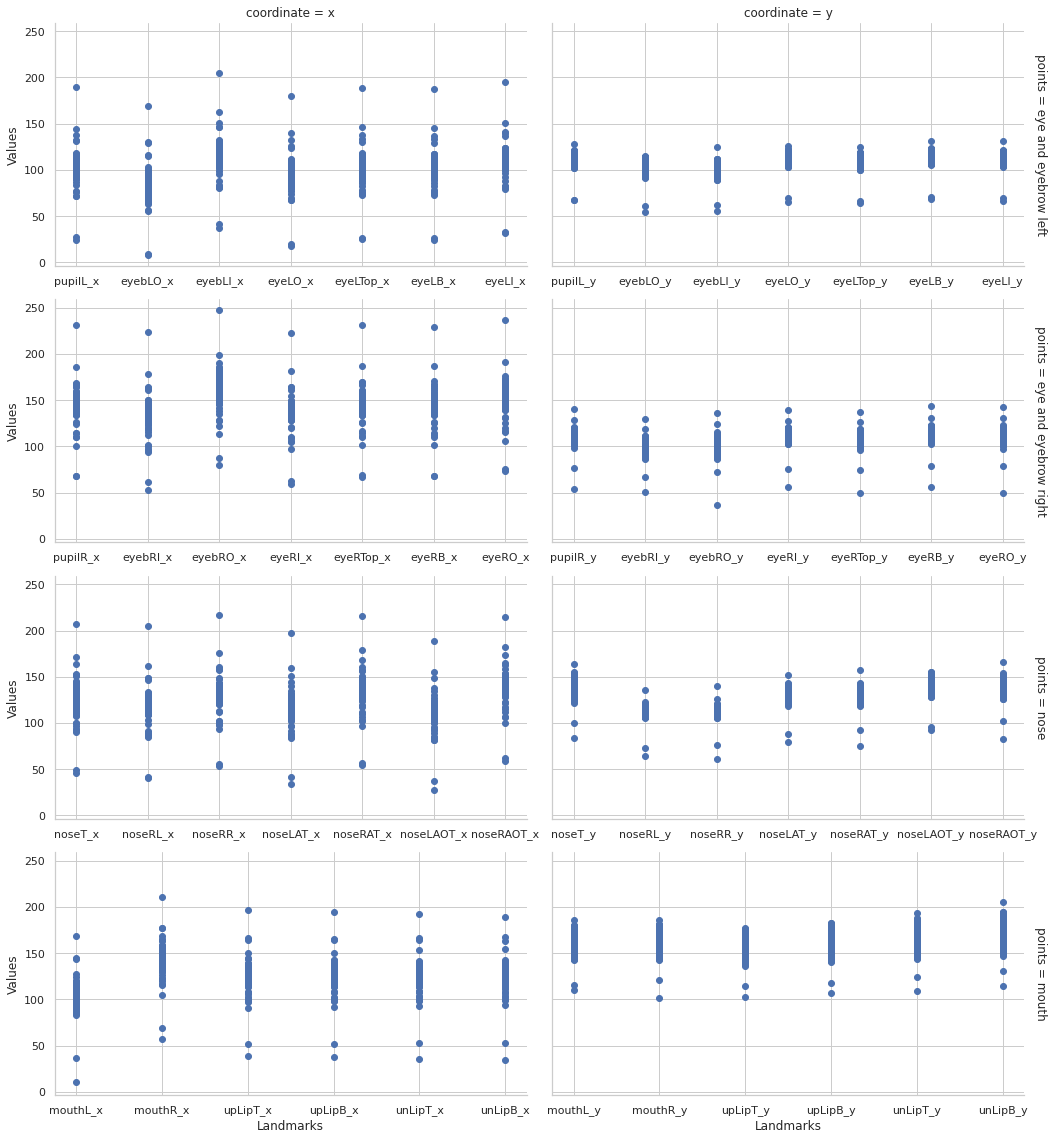

In [0]:
landmarks_names.append('label')

# cria uma lista a partir da lista de listas dos novos nomes
landmarks_boxplot_names_flat = []
for sublist in landmarks_boxplot_names:
  for item in sublist:
    landmarks_boxplot_names_flat.append(item)

# cria um novo pandas com os dados a serem plotados
landmarks_boxplot = pd.DataFrame (base, columns = landmarks_names)

# dicionário para renomear as colunas
dictionary = {}
for d in range(0,len(landmarks_boxplot_names_flat)):
  dictionary[landmarks_names[d]] = landmarks_boxplot_names_flat[d]

landmarks_boxplot.rename(columns=dictionary, inplace=True)

# rearranja a tabela para exibir os boxplots
landmarks_boxplot = pd.melt(landmarks_boxplot, id_vars=['label'], value_vars=landmarks_boxplot_names_flat) 
# renomeia o eixo x e y global
landmarks_boxplot.rename(columns={'variable':'Landmarks', 'value':'Values'}, inplace=True)

# os boxplots são dispostos em grade de maneira que
# as colunas são separadas em coordenadas x e y dos landmarks
columns = []
for c in landmarks_boxplot['Landmarks']:
  if c in landmarks_boxplot_names[0] or c in landmarks_boxplot_names[2] or c in landmarks_boxplot_names[4] or c in landmarks_boxplot_names[6]:
    columns.append('x')
  elif  c in landmarks_boxplot_names[1] or c in landmarks_boxplot_names[3] or c in landmarks_boxplot_names[5] or c in landmarks_boxplot_names[7]:
    columns.append('y')
  else:
    columns.append('ERROR')

landmarks_boxplot['coordinate'] = columns

# .. e as linhas são sepadadas pelos grupos de pontos
columns = []
for c in landmarks_boxplot['Landmarks']:
  if c in landmarks_boxplot_names[0] or c in landmarks_boxplot_names[1]:
    columns.append('eye and eyebrow left')
  elif  c in landmarks_boxplot_names[2] or c in landmarks_boxplot_names[3]:
    columns.append('eye and eyebrow right')
  elif  c in landmarks_boxplot_names[4] or c in landmarks_boxplot_names[5]:
    columns.append('nose')
  elif  c in landmarks_boxplot_names[6] or c in landmarks_boxplot_names[7]:
    columns.append('mouth')
  else:
    columns.append('ERROR')

landmarks_boxplot['points'] = columns

# configura a grade de boxplots
sns.set(style="whitegrid")
g = sns.FacetGrid(landmarks_boxplot, col="coordinate", row="points", margin_titles=True, height=4, aspect=1.85, sharex=False)
g.map(plt.scatter, 'Landmarks', 'Values')


# Divisão da base em bases treino e teste

Realiza a separação da base em 80% para treino e 20% para teste. As bases são copiadas para o diretório pessoal do Drive.

In [0]:
nomes = pd.unique(base['label'])
teste = pd.DataFrame(columns=base.columns)
treino = pd.DataFrame(columns=base.columns)

for n in nomes:
  treino = treino.append(base.loc[base['label'] == n][:8])
  teste = teste.append(base.loc[base['label'] == n][8:10])

treino.to_csv('treino_features.csv', index=False) #
teste.to_csv('teste_features.csv', index=False) #

!cp "/content/sample_data/treino_features.csv" "/content/drive/My Drive/"
!cp "/content/sample_data/teste_features.csv" "/content/drive/My Drive/"

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
      age gender  pupilLeft_x  ...  underLipBottom_x  underLipBottom_y  label
0    46.0      0        100.4  ...             127.2             175.1      0
1    45.0      0        106.0  ...             124.1             170.0      0
2    45.0      0        105.7  ...             130.0             165.3      0
3    48.0      0        107.0  ...             117.7             171.7      0
4    44.0      0        102.3  ...             128.2             167.9      0
..    ...    ...          ...  ...               ...               ...    ...
993  46.0      0         98.0  ...             125.7             166.1     99
994  49.0      0        105.4  ...             129.6             161.8

# Requisição do controle das regras de acesso

Realiza a autorização por nome e consulta os autorizados.

In [0]:
#Controle de acesso - WebService Azure
def listAuth():
      
  """
  Realiza a chamada ao webservice e recupera a lista de autorizados.
  
  Parameters
  ----------
  -
      
  Returns
  -------
  response: list
  """
  headers = {'Content-Type':'application/json'}
  return requests.get("https://tpml-api.azurewebsites.net/api/autorizados", params={}, headers=headers)

name_predict = 42

def setAuth(nomes):
  """
    Realiza a chamada ao webservice e informa quem são os novos autorizados, que são recebidos por parâmetro. O serviço irá remover os anteriores.
    
    Parameters
    ----------
    nomes: list
      Lista com os nomes dos autorizados.
        
    Returns
    -------
    response: int
      1: sucesso; 2: falha.
  """
  #Remove todos antes de adicionar novos autorizados
  headers = {'Content-Type':'application/json'}
  response = requests.post("https://tpml-api.azurewebsites.net/api/novo_autorizado", params={}, json=nomes, headers=headers)
  return response.json()

In [0]:
#Extrai feature da imagem
def extrairFeature(path=None, nome=''):
  """
    Realiza a chamada ao webservice e recupera a lista de autorizados.
    
    Parameters
    ----------
    path : string
    nome: string
     Path é a string com o caminho da imagem.
     nome é o nome da pessoa da foto.
        
    Returns
    -------
    ft: list
      ft é lista dos valores das features extraídas da imagem.
  """
  data=None
  response=None

  if path == None or path=='':
    return "Caminho inválido"

  data=open(path, 'r+b').read()
  headers = {'Ocp-Apim-Subscription-Key': KEY, 'Content-Type':'application/octet-stream', 'Content-Length':str(len(data))}
  params = {
    'returnFaceId': 'true',
    'returnFaceLandmarks': 'true',
    'returnFaceAttributes': 'age,gender,smile,headPose,facialHair,glasses,emotion,hair,makeup,occlusion,accessories,blur,exposure,noise',    
}

  while(response == None or not response.ok ):
     # try:
      response = requests.post(face_api_url, params=params, data=data, headers=headers)
      if response.status_code == 429 :
        print("Erro por excesso de requisições. Aguardando ...")
        sleep(60) #caso dê falha de limite de requisiçãão, esperar 1 minuto
        response = None
        continue #reinicia o while
      if not response.json():
        print('fail')
      if response != None and response.ok and response.json(): #code 200 = requisicao ok ; response.json() será True se tiver itens.
        features=generate_new_df(response.json())
        features.insert(loc=len(features.columns), column='label', value=nome)
        #tratamento dos valores not str
        ft=[]
        for f in features.values[0]:
          if type(f) != str:
            ft.append(str(f))
          else:
            ft.append(f)
          
        #fim-tratamento
        return ft
      else:
        print("Erro ", response.status_code, " - Falha na requisição.\n Resposta: ", response.json())
        response = None


A função irá realizar a requisição para o modelo de classificação, gerado no Azure Machine Learning Studio.

In [0]:
import ast
import urllib.request as urllib2
import json 

def predict(features, verbose = False):

  """
  Função que realiza a chamada para o modelo de classificação. 

  Parameters
  ----------
  features : List
    Lista com as features da imagem
  verbose : Boolean
    Valor boleano que indica se é ou não para exibir os prints da função
        
  Returns
  -------
  name_predict : String
    Nome retornado pelo classificador. Em caso de erros no request é retornado o valor 42.
  """

  data = {
        "Inputs": {
              "input1":
                {
                    "ColumnNames": ["age", "gender", "pupilLeft_x", "pupilLeft_y", "pupilRight_x", "pupilRight_y", "noseTip_x", "noseTip_y", "mouthLeft_x", "mouthLeft_y", "mouthRight_x", "mouthRight_y", "eyebrowLeftOuter_x", "eyebrowLeftOuter_y", "eyebrowLeftInner_x", "eyebrowLeftInner_y", "eyeLeftOuter_x", "eyeLeftOuter_y", "eyeLeftTop_x", "eyeLeftTop_y", "eyeLeftBottom_x", "eyeLeftBottom_y", "eyeLeftInner_x", "eyeLeftInner_y", "eyebrowRightInner_x", "eyebrowRightInner_y", "eyebrowRightOuter_x", "eyebrowRightOuter_y", "eyeRightInner_x", "eyeRightInner_y", "eyeRightTop_x", "eyeRightTop_y", "eyeRightBottom_x", "eyeRightBottom_y", "eyeRightOuter_x", "eyeRightOuter_y", "noseRootLeft_x", "noseRootLeft_y", "noseRootRight_x", "noseRootRight_y", "noseLeftAlarTop_x", "noseLeftAlarTop_y", "noseRightAlarTop_x", "noseRightAlarTop_y", "noseLeftAlarOutTip_x", "noseLeftAlarOutTip_y", "noseRightAlarOutTip_x", "noseRightAlarOutTip_y", "upperLipTop_x", "upperLipTop_y", "upperLipBottom_x", "upperLipBottom_y", "underLipTop_x", "underLipTop_y", "underLipBottom_x", "underLipBottom_y", "label"],
                    "Values": [features]
                },        },
            "GlobalParameters": {}
    }

  body = str.encode(json.dumps(data))
  url = 'https://ussouthcentral.services.azureml.net/workspaces/e6426e9d42634af0b9c4b00ee8e18b0b/services/d2ea1de76527492689996e4b0f61e862/execute?api-version=2.0&details=true'
  api_key = 'SXwgIZSg5uEP579xEzAQIjD/bKDJolzPFCzfYYGdMPcKZ0wc0hF60lCSdzuxuqnWhTfLMoRivXFskD7vKZlQzw==' # Replace this with the API key for the web service
  headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key)}
  req = urllib2.Request(url, body, headers) 

  try:

    response = urllib2.urlopen(req)
    result = response.read()
    result = ast.literal_eval(result.decode('utf-8'))
    name_predict = result['Results']['output1']['value']['Values'][0][-1]

    if(verbose == True):
      print("Predict: " + name_predict)

  except urllib2.HTTPError:

    if(verbose == True):
      print("The request failed with status code: " + str(error.code))
      print(error.info())
      print(json.loads(error.read())) 

    name_predict = 42

  return name_predict

In [0]:
#Realiza as autorizações
#

def main(path_img='', nome=''):
  if path_img == '': 
    path_img='/content/sample_data/lfw-deepfunneled/lfw-deepfunneled/Tocker_Pudwill/Tocker_Pudwill_0001.jpg' #as imangens do Kaggle precisam estar no Colab
  if nome == '':
    nome='Tocker_Pudwill'
  
  features = extrairFeature(path_img, nome)
  #ft_test = [ "0", "value", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "value"]
  name_predict = predict(features)
  autorizados = listAuth().json()['autorizados'] #Verifica quem é autorizado

  print("\nNome real: ", nome)
  if(name_predict == 42):
    print("Erro na predição!")
  else: 
    if(name_predict in autorizados):
      
      print('\n', name_predict.replace("_"," ") + " : Autorizado")
    else: 
      
      print('\n', name_predict.replace("_"," ") + " : Não Autorizado")
  
if __name__ == "__main__":
  resp=setAuth({"nomes":['George_W_Bush','Laura_Bush']}) #default
  op = -1
  while(op != 0):
    op = int(input("\nDigite o número da opção que deseja: \n1 para verificar as autorizações atuais; \n2 para alterar o nome dos autorizados; \n3 para verificar se uma pessoa é autorizada; \n0 para sair\n"))
    if op==1:
      print("\nAutorizados: ", listAuth().json()['autorizados'],'\n')
    if op==2:
      d = -1
      nomesAuth=[]
      while(d != 0):
        nomesAuth.append(input("\nDigite um nome de autorizado: "))
        d = int(input("\nSe não quer mais adicionar nomes de autorizados, digite 0. Caso queira adicionar mais, digite outro numero qualquer\n"))
      print(nomesAuth)
      resp=setAuth({"nomes":nomesAuth})
      if resp['resultado'] == 1:
        print("\nAutorização realizado com sucesso.\n")
      else: 
        print("\nErro na autorização.\n")
    if op==3:
      
      path=input("\nCaso tenha uma imagem para avaliar autorização, digite o caminho da imagem no diretório do Google. Senão, deixe em branco.")
      nome=input("\nDigite o nome da pessoa na imagem. Senão, deixe em branco.")
      main(path, nome)
    if op==0:
      print("\nTchau !")
      break
  

Digite o número da opção que deseja: 
1 para verificar as autorizações atuais; 
2 para alterar o nome dos autorizados; 
3 para verificar se uma pessoa é autorizada; 
0 para sair
3
Caso tenha uma imagem para avaliar autorização, digite o caminho da imagem no diretório do Google. Senão, deixe em branco.
Digite o nome da pessoa na imagem. Senão, deixe em branco.
Nome real:  Tocker_Pudwill
Jason Kidd : Não Autorizado
Digite o número da opção que deseja: 
1 para verificar as autorizações atuais; 
2 para alterar o nome dos autorizados; 
3 para verificar se uma pessoa é autorizada; 
0 para sair
0
Tchau !
